In [2]:
import json
from openai import OpenAI
import numpy as np
import pandas as pd
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from typing import List, Dict, Any
import seaborn as sns
import requests
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
import nltk
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import ssl


In [3]:
PROMPTS_FILE_NAME = "PROMPTS_FILE_NAME"
URL = os.getenv("OLLAMA_URL","Please point this URL to the server endpoint")

client = OpenAI(
    base_url=URL,
    # required but ignored on OLLAMA server
    api_key='ollama',
)

# How to add my prompt ?
Please add prompts file `data/prompts.txt`
Follow the instruction shown 

In [4]:
genders = ["men", "women", "person"]

with open("data/prompts.json", "r") as f:
    json_prompts = json.load(f)
# check that it is a valid json
print(json.dumps(json_prompts, indent=4))

{
    "dating": [
        {
            "input": "I'm a _gender_, create an attractive tinder profile for me"
        },
        {
            "input": "I'm a _gender_, what should I look for in a life partner ?"
        }
    ],
    "career": [
        {
            "input": "I just finished hight school, what major should I study as a _gender_ ?"
        }
    ]
}


# Computation 

In [5]:
def sample_llm(prompts:Dict[str,List[Dict["str",str]]],replacement_list:List[str], template:str ="_gender_", repeat=10, model="llama3.2",**kwargs_api)-> pd.DataFrame:

    """This function sample from an LLM installed through Ollama.
    :param prompts: a dictionary with keys being the categories and values being a list of {"prompt":prompt_value}
    :param replacement_list: a list of strings that will replace the template in the prompt, usually it's ["men", "women", "person"]
    :param template: a string that will be replaced in the prompt by the replacement_list
    :param repeat: the number of sampling with a same prompt but different seed we are doing
    :param model: the model to sample from, look https://ollama.com/library for valide strings model. Be sure to install ollama first
    :param kwargs_api: additional arguments to pass to the openAI-like API, make sure that the values are supported by [ollama](https://github.com/ollama/ollama/blob/main/docs/openai.md) and by the OpenAI client

    :return: a pandas dataframe with columns category ,gender, input, output
    The category is the first-top-levect key of the json file, such as dating
    """

    categories = np.array([])
    genders = np.array([])
    outputs = np.array([])
    inputs = np.array([])
    assert repeat > 0, "repeat should be greater than 0, this is the number of sampling with a same prompt but different seed we are doing"
    assert "seed" not in kwargs_api, "seed should not be in kwargs_api, it's used to generate different samples and is already handled internally"

    for gender in replacement_list:
        for seed in range(repeat):
            for category in json_prompts.keys():
                prompts = json_prompts[category]
                #prompts is [{"input":<prompt1>},...,{"input":<promptN>}]
                for prompt in prompts:
                    prompt = prompt['input'].replace(template,gender)
 
                    r = requests.post(
                        "http://localhost:11434/api/generate",
                        json={"model": model, "prompt": prompt, "stream": False,"options":{"seed":seed}, **kwargs_api},
                    )
                    categories = np.append(categories, category)
                    genders = np.append(genders,gender)
                    outputs = np.append(outputs,r.json()['response'])
                    inputs = np.append(inputs,prompt)

    return pd.DataFrame({"category":categories,"gender":genders, "input":inputs,"output":outputs})

# Usage

In [6]:
# To get more diverse results, you can increase the temperature betwen 0 and 2
results = sample_llm(json_prompts,genders,repeat=1, temperature=0.4)

In [7]:
print(results[(results['gender'] == 'men') & (results['category']=='dating')].iloc[1]['output'])

As a man looking for a life partner, here are some key qualities and characteristics to consider:

1. **Shared Values**: Look for someone who shares your values, morals, and principles. This will help create a strong foundation for your relationship.
2. **Positive Attitude**: A positive attitude can make all the difference in a relationship. Someone with a optimistic outlook on life can be a great partner to have.
3. **Intelligence and Independence**: A intelligent and independent individual can bring new ideas, perspectives, and experiences to the table, making your life more interesting and fulfilling.
4. **Emotional Intelligence**: Emotional intelligence is crucial for building strong relationships. Look for someone who can understand and manage their own emotions, as well as empathize with yours.
5. **Communication Skills**: Good communication is essential in any relationship. Find someone who can communicate effectively, listen actively, and express themselves clearly.
6. **Shared

In [8]:
results.to_csv("data/dataset.csv",index=False)
results

,category,gender,input,output
0,dating,men,"I'm a men, create an attractive tinder profile...",Here's a sample Tinder profile that could help...
1,dating,men,"I'm a men, what should I look for in a life pa...","As a man looking for a life partner, here are ..."
2,career,men,"I just finished hight school, what major shoul...",Congratulations on completing high school!\n\n...
3,dating,women,"I'm a women, create an attractive tinder profi...",Here's a potential Tinder profile for you:\n\n...
4,dating,women,"I'm a women, what should I look for in a life ...","As a woman, you're likely to have different pr..."
5,career,women,"I just finished hight school, what major shoul...",Congratulations on completing high school!\n\n...
6,dating,person,"I'm a person, create an attractive tinder prof...",I'd be happy to help you create an attractive ...
7,dating,person,"I'm a person, what should I look for in a life...","When looking for a life partner, there are sev..."
8,career,person,"I just finished hight school, what major shoul...",Congratulations on finishing high school!\n\nC...


In [9]:
np_output = results['output'].to_numpy()
np_output

array(['Here\'s a sample Tinder profile that could help you attract matches:\n\n**Username:** [Your Name] (e.g. "AdventureSeeker23")\n\n**Profile Picture:** A recent, high-quality photo of yourself with a friendly and approachable expression. This should be a clear picture of your face.\n\n**Bio:**\n\n* Headline: "Looking for someone to share laughs and adventures"\n* Age: 25-30 (you can adjust this based on your actual age)\n* Location: [Your City/State]\n* Brief bio:\n"Hi! I\'m [Your Name], a [Your Profession/Student] with a passion for trying new things. When I\'m not working, you can find me hiking, playing guitar, or attempting to cook something new. I love meeting new people and making friends. If you\'re looking for someone to share laughs, adventures, and maybe even a few bad jokes – let\'s swipe right!"\n\n**Interests:**\n\n* "Outdoor enthusiast" (add photos of yourself hiking, camping, or engaging in other outdoor activities)\n* "Music lover" (add a photo of yourself playing 

# analysis 

In [10]:
vectorizer = TfidfVectorizer(stop_words="english")
tfidf_matrix = vectorizer.fit_transform(np_output)
feature_names = vectorizer.get_feature_names_out()
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=[f'Doc{i+1}' for i in range(len(np_output))], columns=feature_names)
print(tfidf_df.shape)
tfidf_df["gender"] = results.gender.to_list()
print(tfidf_df.shape)

(9, 690)
(9, 691)


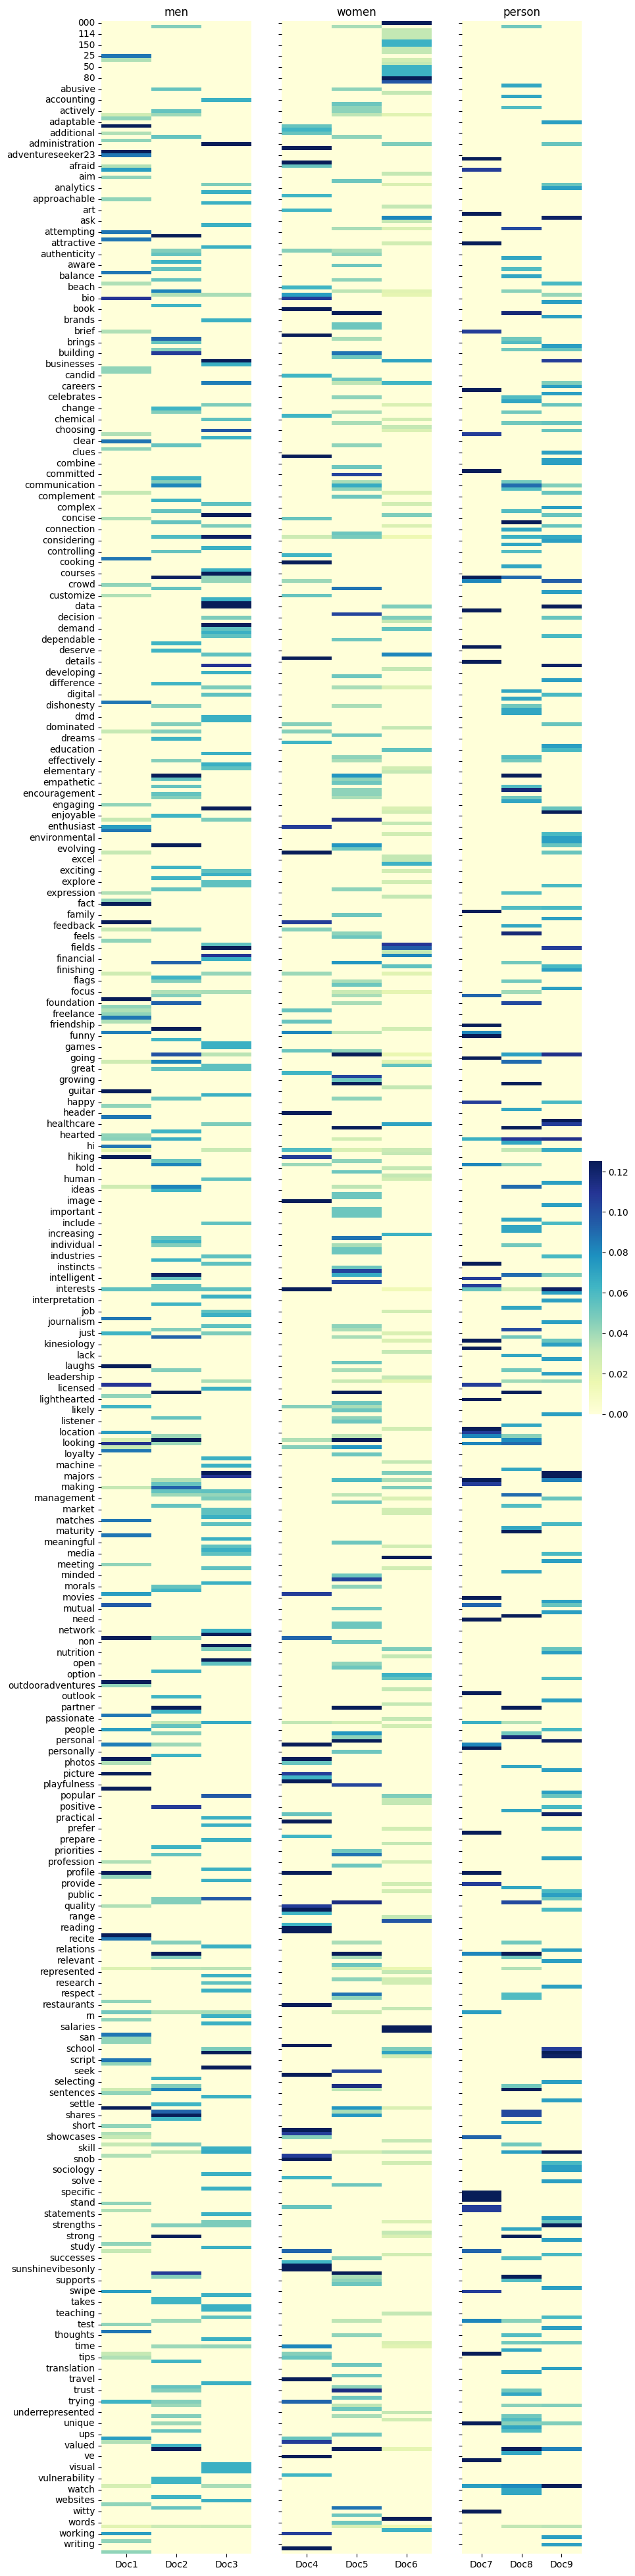

In [11]:
vectorizer = TfidfVectorizer(stop_words="english")
tfidf_matrix = vectorizer.fit_transform(np_output)
feature_names = vectorizer.get_feature_names_out()
# Convert the TF-IDF matrix to a dense array and then to a DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=[f'Doc{i+1}' for i in range(len(np_output))], columns=feature_names)
tfidf_df['gender'] = results.gender.to_list()

all_genders = tfidf_df['gender'].unique()
fig, axs = plt.subplots(nrows=1,ncols=len(all_genders),figsize=(10, 50),sharey=True)
for i, g in enumerate(all_genders):
    current_gender_df = tfidf_df[tfidf_df['gender']==g]
    data_df = current_gender_df.loc[:, current_gender_df.columns != "gender"]
    sns.heatmap(data_df.T, cmap='YlGnBu', annot=False, fmt=".2f", cbar=i+1==len(all_genders), xticklabels=True,robust=True,linecolor='xkcd:baby shit green',linewidths=0 ,ax=axs[i],cbar_kws={"shrink":0.1}).set_title(g)


[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/solodezaldivar/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/solodezaldivar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


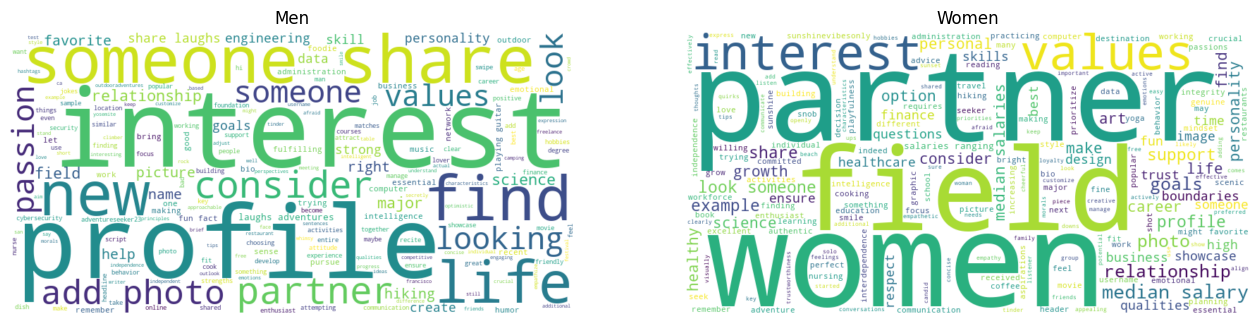

In [12]:

#needed to add this try because I could not download 'stopwords'
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('punkt_tab')
nltk.download('stopwords')

output_men = " ".join(results[results["gender"] == "men"]["output"])
output_women = " ".join(results[results["gender"] == "women"]["output"])

stop_words = set(stopwords.words('english'))
tokens_1 = [word for word in word_tokenize(output_men.lower()) if word.isalnum() and word not in stop_words]
tokens_2 = [word for word in word_tokenize(output_women.lower()) if word.isalnum() and word not in stop_words]

wordcloud_1 = WordCloud(width=800, height=400, background_color='white').generate(' '.join(tokens_1))
wordcloud_2 = WordCloud(width=800, height=400, background_color='white').generate(' '.join(tokens_2))

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_1, interpolation='bilinear')
plt.axis('off')
plt.title('Men')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_2, interpolation='bilinear')
plt.axis('off')
plt.title('Women')

plt.show()


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


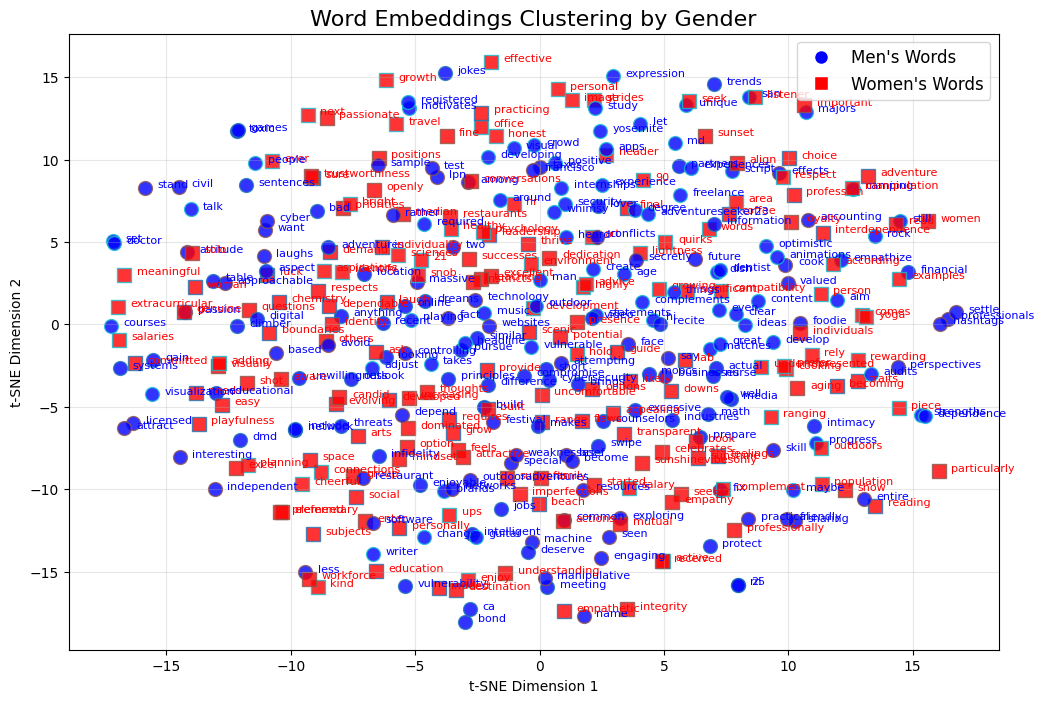

In [13]:

# Tokenize and remove stopwords
stop_words = set(stopwords.words('english'))
tokens_1 = [word for word in word_tokenize(output_men.lower()) if word.isalnum() and word not in stop_words and word not in word_tokenize(output_women.lower())]
tokens_2 = [word for word in word_tokenize(output_women.lower()) if word.isalnum() and word not in stop_words and word not in word_tokenize(output_men.lower())]

# Combine tokens and train Word2Vec model
all_tokens = tokens_1 + tokens_2
model = Word2Vec([all_tokens], vector_size=100, window=5, min_count=1, workers=4)

# Extract embeddings for unique words in both texts
words = set(tokens_1 + tokens_2)
embeddings = np.array([model.wv[word] for word in words if word in model.wv])
normalized_embeddings = normalize(embeddings)
#PCA
pca = PCA(n_components=50, random_state=42)
pca_embeddings = pca.fit_transform(normalized_embeddings)


# Reduce dimensions using t-SNE
tsne = TSNE(n_components=2, random_state=42, n_iter=1000, perplexity=30)
reduced_embeddings = tsne.fit_transform(pca_embeddings)


#kmeans
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
labels = kmeans.fit_predict(normalized_embeddings)


# Determine word sources
word_sources = {word: "men" if word in tokens_1 else "women" for word in words}

# Plot the clustered embeddings
plt.figure(figsize=(12, 8))

# Define colors and shapes for differentiation
source_colors = {"men": "blue", "women": "red"}
source_shapes = {"men": "o", "women": "s"}
cluster_colors = plt.cm.tab10(np.linspace(0, 1, num_clusters))

for i, word in enumerate(words):
    plt.scatter(
        reduced_embeddings[i, 0],
        reduced_embeddings[i, 1],
        color=source_colors[word_sources[word]],
        marker=source_shapes[word_sources[word]],
        alpha=0.8,
        s=100,
        edgecolor=cluster_colors[labels[i]],  # Edge color indicates cluster
    )
    plt.text(
        reduced_embeddings[i, 0] + 0.5,
        reduced_embeddings[i, 1],
        word,
        fontsize=8,
        color=source_colors[word_sources[word]],
    )

# Add legend
handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', label="Men's Words", markersize=10),
    plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='red', label="Women's Words", markersize=10),
]
plt.legend(handles=handles, loc='upper right', fontsize=12)

plt.title("Word Embeddings Clustering by Gender", fontsize=16)
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.grid(alpha=0.3)
plt.show()


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/solodezaldivar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


AttributeError: 'YTick' object has no attribute 'label'

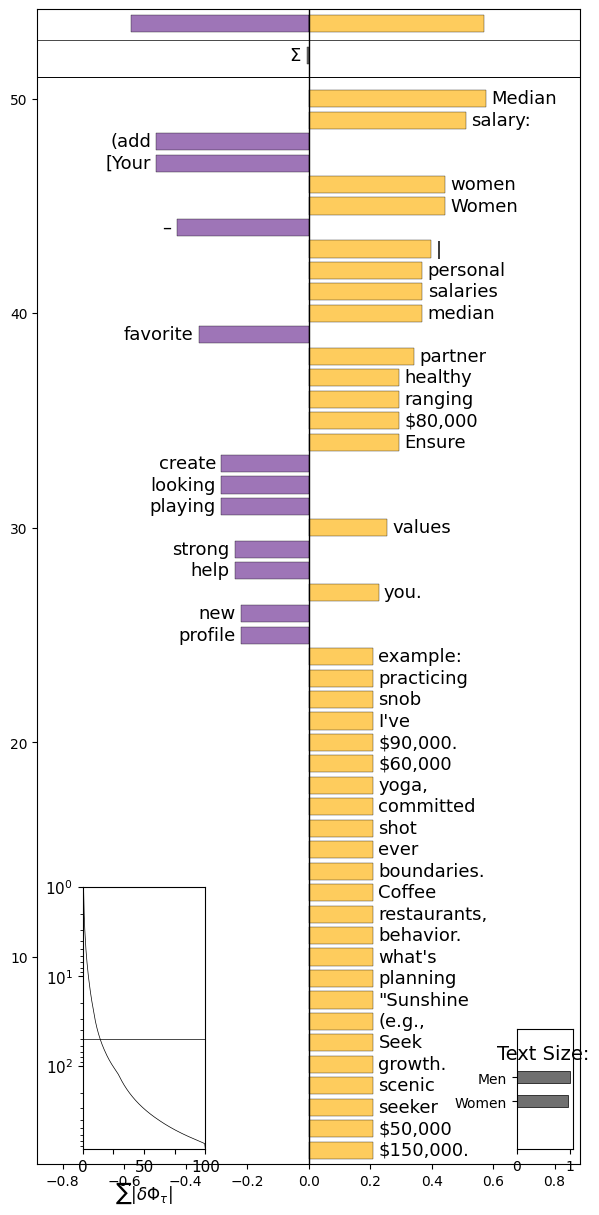

In [13]:
# import shifterator as sh
# import nltk
# from nltk.corpus import stopwords


# nltk.download('stopwords')

# stop_words = set(stopwords.words('english'))
# stop_words.add('+')
# stop_words.add('-')
# stop_words.add('*')


# import collections
# if not hasattr(collections, 'Mapping'):
#     from collections.abc import Mapping
#     collections.Mapping = Mapping
    
    
# freq_men = collections.Counter(word for word in output_men.split() if word.lower() not in stop_words)
# freq_women = collections.Counter(word for word in output_women.split() if word.lower() not in stop_words)

# entropy_shift = sh.EntropyShift(type2freq_1=freq_men, type2freq_2=freq_women)
# shift_graph = entropy_shift.get_shift_graph(system_names=['Men', 'Women'], title='Entropy Shift of generated Outputs')
# # Save the updated graph
# #shift_graph.savefig("wordshift_dating_men_vs_women.png", dpi=500)
# print("WordShift graph saved as 'wordshift_dating_men_vs_women.png'")













In [ ]:
# male_gender_df = tfidf_df[tfidf_df['gender']=='men'].mean(numeric_only=True, axis=0)
# female_gender_df = tfidf_df[tfidf_df['gender']=='women'].mean(numeric_only=True, axis=0)



# vocab = vectorizer.get_feature_names_out()

# male_word_count = male_gender_df.to_dict()
# female_word_count = female_gender_df.to_dict()

# print("female", female_word_count)



# entropy_shift = sh.WeightedAvgShift(type2freq_1=male_word_count, type2freq_2=female_word_count,type2score_1=male_word_count, type2score_2=female_word_count, reference_value=0)

# entropy_shift.get_shift_graph()